#### Cohort Analysis on Regional Manager Activity
<br>
Key steps in the analysis:
<br>
1. Check for and remove bad data
<br>
2. Check for lead duplication

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

## Ingest data

In [3]:
## ingest excel sheet
orig = pd.read_excel('ap_test.xlsx')
print(orig.shape)
orig.head(2)

(6353, 6)


,Lead Creation Date,Lead ID,RVP Region,Regional Manager,Date Activity,Move-ins Booked
0,2021-05-05,20320836,RVP1,RM1,2021-06-01,1
1,2021-05-06,17483490,RVP1,RM2,2021-06-01,1


## Data exploration

In [4]:
## info() to check for missing data + confirm datetime format for date columns
orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6353 entries, 0 to 6352
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Lead Creation Date  6353 non-null   datetime64[ns]
 1   Lead ID             6353 non-null   object        
 2   RVP Region          6353 non-null   object        
 3   Regional Manager    6353 non-null   object        
 4   Date Activity       6353 non-null   datetime64[ns]
 5   Move-ins Booked     6353 non-null   int64         
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 297.9+ KB


In [5]:
## not all leads ids are unique
orig['Lead ID'].nunique()

6343

In [6]:
## explore data distribution of RVP Region
print(orig['RVP Region'].nunique())
orig['RVP Region'].value_counts()

6


RVP4    1741
RVP1    1719
RVP2    1460
RVP6     710
RVP5     637
RVP3      86
Name: RVP Region, dtype: int64

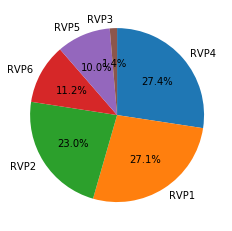

In [7]:
## visualise data distribution of RVP Region
fig1, ax1 = plt.subplots()
ax1.pie(
    x = orig['RVP Region'].value_counts().values,
    labels = orig['RVP Region'].value_counts().index,
    autopct='%1.1f%%',
    counterclock=False,
    startangle=90)

plt.show()

In [8]:
## double check if regional managers have activity over multiple regions; confirmed No
orig.groupby(['RVP Region', 'Regional Manager'])['Regional Manager'].count()

RVP Region  Regional Manager
RVP1        RM1                 425
            RM2                 420
            RM3                 313
            RM4                 561
RVP2        RM5                 503
            RM6                 472
            RM7                 485
RVP3        RM8                  86
RVP4        RM10                306
            RM11                443
            RM12                579
            RM9                 413
RVP5        RM13                217
            RM14                326
            RM17                 94
RVP6        RM15                311
            RM16                399
Name: Regional Manager, dtype: int64

In [9]:
## explore date ranges
l_min = orig['Lead Creation Date'].min().date()
l_max = orig['Lead Creation Date'].max().date()
d_min = orig['Date Activity'].min().date()
d_max = orig['Date Activity'].max().date()

print(f"Lead create date range between {l_min} and {l_max}.")
print(f"Activity date range between {d_min} and {d_max}.")

Lead create date range between 2021-04-02 and 2021-05-11.
Activity date range between 2021-06-01 and 2021-07-19.


In [10]:
## very few move-ins booked exceed 1
orig['Move-ins Booked'].value_counts()

1    6350
2       2
3       1
Name: Move-ins Booked, dtype: int64

In [11]:
## examine entries with move-ins books > 1
## see that these only apply to managers RM8, and have no lead id
orig[orig['Move-ins Booked'] != 1]

,Lead Creation Date,Lead ID,RVP Region,Regional Manager,Date Activity,Move-ins Booked
1045,2021-04-09,No Value,RVP3,RM8,2021-06-11,2
2802,2021-04-05,No Value,RVP3,RM8,2021-06-25,2
4056,2021-04-08,No Value,RVP3,RM8,2021-06-30,3


In [12]:
## check which lead ids aren't in numeric format; a good indicator for potential bad data
## see that 11 entries have no value
orig['lead_id_checker'] = pd.to_numeric(orig['Lead ID'], errors='coerce')

orig[orig['lead_id_checker'].isna()]

,Lead Creation Date,Lead ID,RVP Region,Regional Manager,Date Activity,Move-ins Booked,lead_id_checker
48,2021-05-07,No Value,RVP3,RM8,2021-06-01,1,NaN
777,2021-05-04,No Value,RVP3,RM8,2021-06-09,1,NaN
917,2021-04-21,No Value,RVP3,RM8,2021-06-10,1,NaN
1045,2021-04-09,No Value,RVP3,RM8,2021-06-11,2,NaN
1732,2021-04-02,No Value,RVP3,RM8,2021-06-17,1,NaN
2111,2021-04-12,No Value,RVP3,RM8,2021-06-21,1,NaN
2592,2021-05-05,No Value,RVP3,RM8,2021-06-24,1,NaN
2802,2021-04-05,No Value,RVP3,RM8,2021-06-25,2,NaN
3387,2021-04-10,No Value,RVP3,RM8,2021-06-29,1,NaN
4056,2021-04-08,No Value,RVP3,RM8,2021-06-30,3,NaN


#### Logic for dealing with bad data:
<br>
In a real scenario, I would examine valid reasons for lead ids having no value, potential reason may include system lag, i.e. a lead is valid, but the id is generated at a later time after a certain system event happens.

If the lag assumption is incorrect, I would review these cases with manager RM8 to identify if this was a data entry error, and correct these entries if possible.

In this simulated scenario, I will remove these entries with no lead ids as bad data. As an added bonus this also removes the entries with move-ins books > 1, which is likely also bad data.

In [13]:
## drop rows where lead ids have no value
## recheck that lead id column now only have unique ids
orig = orig[orig['lead_id_checker'].notna()]

print(orig.shape)
print(orig['Lead ID'].nunique())

(6342, 7)
6342


In [14]:
## drop column lead_id_checker as it is no longer needed
orig.drop(columns=['lead_id_checker'], inplace=True)
orig.head(2)

,Lead Creation Date,Lead ID,RVP Region,Regional Manager,Date Activity,Move-ins Booked
0,2021-05-05,20320836,RVP1,RM1,2021-06-01,1
1,2021-05-06,17483490,RVP1,RM2,2021-06-01,1


In [15]:
## explore the nature of duplication in the data
## duplication is very common
## a manager can have multiple leads that are created and booked on the same days
check_col = ['Lead Creation Date', 'RVP Region', 'Regional Manager', 'Date Activity']
print(orig[orig.duplicated(subset=check_col)].shape)
orig[orig.duplicated(subset=check_col)].head(2)

(1118, 6)


,Lead Creation Date,Lead ID,RVP Region,Regional Manager,Date Activity,Move-ins Booked
22,2021-04-03,20342438,RVP1,RM4,2021-06-01,1
43,2021-05-10,20411887,RVP2,RM7,2021-06-01,1


In [16]:
## visualising a duplicated entry to verify the duplication check is working correctly
orig[
    (orig['Lead Creation Date'] == datetime(2021, 4, 3)) &
    (orig['RVP Region'] == 'RVP1') &
    (orig['Regional Manager'] == 'RM4') &
    (orig['Date Activity'] == datetime(2021, 6, 1))
]

,Lead Creation Date,Lead ID,RVP Region,Regional Manager,Date Activity,Move-ins Booked
20,2021-04-03,20279350,RVP1,RM4,2021-06-01,1
22,2021-04-03,20342438,RVP1,RM4,2021-06-01,1


#### Logic for dealing with duplicated entries:
<br>
In a real scenario where there is more lead-specific info, I would use the additional info to look for actual duplication. It is not uncommon for sales people to sometime artificially inflate numbers using duplication.

However in this simulated scenario with limited lead-specific info, the duplicated entries seem legit, as a manager can juggle multiple leads, with these leads being created and booked on the same days. Doing this duplication check also provides better intuition for the data scientist on the volumn of activity of a manager.

## Cohort Analysis

In [17]:
orig.columns

Index(['Lead Creation Date', 'Lead ID', 'RVP Region', 'Regional Manager',
       'Date Activity', 'Move-ins Booked'],
      dtype='object')

In [18]:
orig.head()

,Lead Creation Date,Lead ID,RVP Region,Regional Manager,Date Activity,Move-ins Booked
0,2021-05-05,20320836,RVP1,RM1,2021-06-01,1
1,2021-05-06,17483490,RVP1,RM2,2021-06-01,1
2,2021-04-11,18715633,RVP1,RM2,2021-06-01,1
3,2021-04-15,20180732,RVP1,RM2,2021-06-01,1
4,2021-04-17,20182098,RVP1,RM2,2021-06-01,1
